<a href="https://colab.research.google.com/github/mz-zarei/CGAN-EB/blob/main/CGAN_transferability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libs**

In [1]:
import nbeb
import importlib
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from scipy import stats
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Activation
from keras import activations
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ELU, ReLU, concatenate
from keras.layers import Dropout
from matplotlib import pyplot
from keras import Input, Model
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt


seed = 42

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Define Functions**

In [2]:
#####################################
###=== CGAN training Functions ===###
#####################################
# define the standalone discriminator model
x_size = 2

def define_discriminator(in_shape=(1,)):
    y = Input(shape=in_shape, dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    label = Input(shape=(x_size,))
    label_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(label)

    concat = concatenate([y_output, label_output])
    concat = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(concat)
    concat = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(concat)
    validity = Dense(1, activation="sigmoid", kernel_initializer=random_uniform)(concat)

    model = Model(inputs=[y, label], outputs=validity)

    # compile model
    opt = Adam(learning_rate=dis_lr, beta_1=0.5, decay=dis_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, in_shape=(x_size,)):
    x = Input(shape=in_shape, dtype='float')
    x_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(x)

    noise = Input(shape=(latent_dim,))
    noise_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(noise)

    concat = concatenate([x_output, noise_output])

    output = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(concat)
    output = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(1, activation="relu", kernel_initializer=random_normal)(output)

    model = Model(inputs=[noise, x], outputs=output)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get output from the generator model
    gen_output = g_model.output
    # connect output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=gen_lr, beta_1=0.5, decay=gen_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training set
def load_real_samples(x_train,y_train):

    trainX = x_train.to_numpy()
    trainY = y_train.to_numpy()

    return [trainX, trainY]

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset[0].shape[0], n_samples)
    # retrieve selected images
    X_labels, y = dataset[0][ix], dataset[1][ix]
    # generate 'real' class labels (1)
    real = ones((n_samples, 1))
    return [y, X_labels], real

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, x_train):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples) #randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    idx = np.random.randint(0, x_train.shape[0], n_samples)
    X_labels = dataset[0][idx]
    return [z_input, X_labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, x_train):
    # generate points in latent space
    z_input, X_labels_input = generate_latent_points(latent_dim, n_samples, x_train)
    # predict outputs
    samples = generator.predict([z_input, X_labels_input])
    # create class labels
    fake = zeros((n_samples, 1))
    return [samples, X_labels_input], fake

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='Dis loss real')
    pyplot.plot(d2_hist, label='Dis loss fake')
    pyplot.plot(g_hist, label='Gen loss')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, x_train, name, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples, x_train)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = './%s_generator_model_%s.h5' % (name, epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch, x_train, name):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    d1_hist, d2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [y_real, X_labels_real], real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([y_real, X_labels_real], real)
            # generate 'fake' examples
            [y_fake, X_labels], fake = generate_fake_samples(g_model, latent_dim, half_batch, x_train)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([y_fake, X_labels], fake)
            # prepare points in latent space as input for the generator
            [z_input, X_labels_input] = generate_latent_points(latent_dim, n_batch, x_train)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, X_labels_input], y_gan)

        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        # evaluate the model performance, sometimes
        if (i+1) % 100 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim, x_train, name)
            print('Epoch: %d, dLoss real = %.3f, dLoss fake = %.3f, gLoss = %.3f' % (i+1, d_loss1, d_loss2, g_loss))
    plot_history(d1_hist, d2_hist, g_hist)
    return d1_hist, d2_hist, g_hist

# predict y given x
def predict_by_GAN(generator, xtest):
    noise = np.random.normal(0, 1, (xtest.shape[0], 1))
    ypred = generator.predict([noise, xtest])
    ypred[ypred<0] = 0
    return np.array(ypred)

# predict n_samples of y for each x test
def sample_from_GAN(GAN, xtest, n_samples):
    y_samples_gan = predict_by_GAN(GAN, xtest)
    for i in range(n_samples - 1):
        ypred_gan = predict_by_GAN(GAN, xtest)
        y_samples_gan = np.hstack([y_samples_gan, ypred_gan])
    median = []
    mean = []
    Var = []
    for j in range(y_samples_gan.shape[0]):
        median.append(np.median(y_samples_gan[j, :]))
        mean.append(np.mean(y_samples_gan[j, :]))
        Var.append(np.var(y_samples_gan[j, :]))
    return np.array(median).reshape(1,-1)[0], np.array(Var).reshape(1,-1)[0] , np.array(mean).reshape(1,-1)[0], y_samples_gan


# Mean abs percentage error
def MAPE(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    res = []
    for j in range(len(actual)):
        if actual[j] != 0:
            res.append((actual[j] - predicted[j]) / actual[j])
        else:
            res.append(predicted[j] / np.mean(actual))
    return np.mean(np.abs(np.array(res)))


# **Load Crash Data Sets**

In [5]:
# Read df1 = Peel crash data set
df1 = pd.read_excel('/content/Peel_Python_Data.xlsx')
df1 = df1[['Group', 'Year', 'Fmaj', 'Fmin', 'PDO']].copy()
df1 = df1[df1['Year'] > 2013]         # four years
df1 = df1[df1['Group'] == 1]          # group 1

df1['log_Fmaj'] = np.log(df1['Fmaj'])
df1['log_Fmin'] = np.log(df1['Fmin'])
df1.describe()

,Group,Year,Fmaj,Fmin,PDO,log_Fmaj,log_Fmin
count,1316.0,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000
mean,1.0,2015.500000,34080.338146,11897.149696,9.239362,10.316535,8.926354
std,0.0,1.118459,14237.198730,11062.437594,9.555903,0.547925,1.051580
min,1.0,2014.000000,2505.000000,24.000000,0.000000,7.826044,3.178054
25%,1.0,2014.750000,25030.250000,4067.500000,2.000000,10.127840,8.310784
50%,1.0,2015.500000,33956.500000,8057.000000,6.000000,10.432836,8.994295
75%,1.0,2016.250000,44285.250000,16031.000000,14.000000,10.698406,9.682280
max,1.0,2017.000000,79071.000000,55742.000000,55.000000,11.278101,10.928489


In [6]:
# Read df2 = Niagara crash data set
df2 = pd.read_excel('/content/Niagara_Python_Data.xlsx')
df2 = df2[['Group', 'Year', 'Fmaj', 'Fmin', 'PDO']].copy()
df2 = df2[df2['Year'] > 2014]          # four years
df2 = df2[df2['Group'] == 1]           # group 1

df2['log_Fmaj'] = np.log(df2['Fmaj'])
df2['log_Fmin'] = np.log(df2['Fmin'])
df2.describe()

,Group,Year,Fmaj,Fmin,PDO,log_Fmaj,log_Fmin
count,892.0,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,1.0,2016.500000,13576.853139,5616.855381,4.173767,9.398038,8.356094
std,0.0,1.118661,6750.017513,3986.034734,4.517837,0.500420,0.809207
min,1.0,2015.000000,2111.000000,199.000000,0.000000,7.654917,5.293305
25%,1.0,2015.750000,9114.750000,2540.750000,1.000000,9.117649,7.840214
50%,1.0,2016.500000,12290.500000,4626.000000,3.000000,9.416582,8.439447
75%,1.0,2017.250000,17033.500000,7637.500000,6.000000,9.742937,8.940825
max,1.0,2018.000000,63102.000000,27518.000000,32.000000,11.052508,10.222596


# **Fit NB1 and NB2**

In [39]:
x_features = ['log_Fmin', 'log_Fmaj']
y_name = 'PDO'

# Fit NB1 on df1
significant_features = nbeb.forward_regression(df1, x_features, y_name=y_name, threshold_in=0.05, verbose=False)
NB_model1, alpha1  = nbeb.fitNB(df1, significant_features, y_name=y_name)
y_pred_NB1 = NB_model1.predict(sm.add_constant(df1[significant_features]))

print(f"Disperson param: {alpha1}")
print(NB_model1.params)
print(NB_model1.summary())

# Fit NB2 on df2
significant_features = nbeb.forward_regression(df2, x_features, y_name=y_name, threshold_in=0.05, verbose=False)
NB_model2, alpha2  = nbeb.fitNB(df2, significant_features, y_name=y_name)
y_pred_NB2 = NB_model2.predict(sm.add_constant(df1[significant_features]))

print(f"Disperson param: {alpha2}")
print(NB_model2.params)
print(NB_model2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Disperson param: 0.16077467013400057
const      -13.060508
log_Fmin     0.699070
log_Fmaj     0.835749
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PDO   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1313
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3641.5
Date:                Thu, 05 May 2022   Deviance:                       1870.6
Time:                        18:41:01   Pearson chi2:                 2.11e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [15]:
significant_features

['log_Fmin', 'log_Fmaj']

In [37]:
print(NB_model1.predict([1, 
                         8.01201823915906, 9.45210938741356]))
print(np.exp(np.dot([1, 8.01201823915906, 9.45210938741356], NB_model1.params)))

[1.55278167]
1.5527816704910504


In [36]:
sm.add_constant(df1[significant_features])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,log_Fmin,log_Fmaj
6,1.0,8.829080,9.836332
7,1.0,8.733433,9.679969
8,1.0,8.673855,9.710267
9,1.0,8.586159,9.640693
16,1.0,9.418005,10.338220
...,...,...,...
7369,1.0,7.626083,10.823153
7406,1.0,9.832850,10.492607
7407,1.0,9.814164,10.438489
7408,1.0,9.799570,10.447555


In [38]:
y_pred_NB1

6        3.789922
7        3.110554
8        3.060178
9        2.715624
16       8.701518
          ...    
7369     3.728852
7406    13.230597
7407    12.481407
7408    12.448682
7409    12.062953
Length: 1316, dtype: float64

# **Fit CGAN1 and CGAN2**

>Accuracy real: 63%, fake: 52%
Epoch: 100, dLoss real = 0.683, dLoss fake = 0.688, gLoss = 0.689
>Accuracy real: 51%, fake: 57%
Epoch: 200, dLoss real = 0.700, dLoss fake = 0.691, gLoss = 0.700
>Accuracy real: 82%, fake: 32%
Epoch: 300, dLoss real = 0.695, dLoss fake = 0.703, gLoss = 0.694
>Accuracy real: 43%, fake: 65%
Epoch: 400, dLoss real = 0.691, dLoss fake = 0.687, gLoss = 0.696
>Accuracy real: 71%, fake: 38%
Epoch: 500, dLoss real = 0.693, dLoss fake = 0.694, gLoss = 0.697


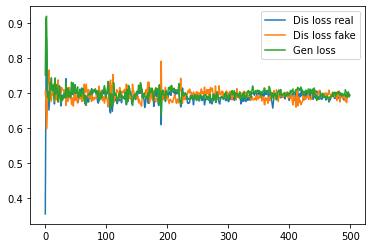

In [ ]:
## Fit CGAN1 on df1
# Sclaing feature vector
scaler1 = StandardScaler().fit(df1[x_features])
x_data_scaled1 = pd.DataFrame(scaler1.transform(df1[x_features]))
x_train1 = x_data_scaled1
y_train1 = df1['PDO']

kerner_initializer = keras.initializers.he_normal(seed=seed)
random_uniform = keras.initializers.RandomUniform(seed=seed)
random_normal = keras.initializers.RandomNormal(seed=seed)
latent_dim, x_size = 1, 2
activation = "elu"

gen_lr, dis_lr, gen_dec, dis_dec, n_epochs, n_batch = 0.001, 0.001, 0.001, 0.001, 500, int(100)  

# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(x_train1,y_train1)
# # train model
d1_hist, d2_hist, g_hist = train(g_model, d_model, gan_model, dataset, 
                                 latent_dim, n_epochs, n_batch, x_train1, name='df1')

>Accuracy real: 56%, fake: 52%
Epoch: 100, dLoss real = 0.687, dLoss fake = 0.688, gLoss = 0.700
>Accuracy real: 12%, fake: 92%
Epoch: 200, dLoss real = 0.712, dLoss fake = 0.675, gLoss = 0.720
>Accuracy real: 41%, fake: 51%
Epoch: 300, dLoss real = 0.693, dLoss fake = 0.690, gLoss = 0.698
>Accuracy real: 68%, fake: 37%
Epoch: 400, dLoss real = 0.687, dLoss fake = 0.694, gLoss = 0.688
>Accuracy real: 57%, fake: 40%
Epoch: 500, dLoss real = 0.682, dLoss fake = 0.705, gLoss = 0.690


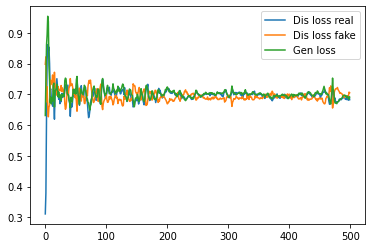

In [ ]:
## Fit CGAN1 on df2
# Sclaing feature vector
scaler2 = StandardScaler().fit(df2[x_features])
x_data_scaled2 = pd.DataFrame(scaler2.transform(df2[x_features]))
x_train2 = x_data_scaled2
y_train2 = df2['PDO']

gen_lr, dis_lr, gen_dec, dis_dec, n_epochs, n_batch = 0.001, 0.001, 0.001, 0.001, 500, int(150)  


# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(x_train2,y_train2)
# # train model
d1_hist, d2_hist, g_hist = train(g_model, d_model, gan_model, dataset, 
                                 latent_dim, n_epochs, n_batch, x_train2, name='df2')

# **Compare Transferability**

In [ ]:
# Load CGAN models
CGAN1 = keras.models.load_model('df1_generator_model_500.h5' , 
                              custom_objects={'LeakyReLU': LeakyReLU(), 
                                              'Activation': Activation(activations.exponential), 
                                              'layers':keras.layers})
CGAN2 = keras.models.load_model('df2_generator_model_500.h5' , 
                              custom_objects={'LeakyReLU': LeakyReLU(), 
                                              'Activation': Activation(activations.exponential), 
                                              'layers':keras.layers})

In [40]:

## Predictions using NB models
pred_df1_by_NB2 = NB_model2.predict(sm.add_constant(df1[x_features]))
pred_df1_by_NB2_cal = pred_df1_by_NB2 * df1['PDO'].sum()/sum(pred_df1_by_NB2)

pred_df2_by_NB1 = NB_model1.predict(sm.add_constant(df2[x_features]))
pred_df2_by_NB1_cal = pred_df2_by_NB1 * df2['PDO'].sum()/sum(pred_df2_by_NB1)

mae_df1 = mean_absolute_error(df1['PDO'], pred_df1_by_NB2_cal)
mse_df1 = mean_squared_error(df1['PDO'], pred_df1_by_NB2_cal)
mape_df1 = MAPE(df1['PDO'], pred_df1_by_NB2_cal)

mae_df2 = mean_absolute_error(df2['PDO'], pred_df2_by_NB1_cal)
mse_df2 = mean_squared_error(df2['PDO'], pred_df2_by_NB1_cal)
mape_df2 = MAPE(df2['PDO'], pred_df2_by_NB1_cal)

print(f"NB models - MAE for df1: {mae_df1}, MAE for df2: {mae_df2}")
print(f"NB models - MSE for df1: {mse_df1}, MSE for df2: {mse_df2}")
print(f"NB models - MAPE for df1: {mape_df1}, MAPE for df2: {mape_df2}")

## Predictions using CGAN models
_,  _, pred_df1_by_CGAN2, _ = sample_from_GAN(CGAN2, np.array(x_data_scaled1), n_samples = 200)
_,  _, pred_df2_by_CGAN1, _ = sample_from_GAN(CGAN1, np.array(x_data_scaled2), n_samples = 200)
pred_df1_by_CGAN2_cal = pred_df1_by_CGAN2 * df1['PDO'].sum()/sum(pred_df1_by_CGAN2)
pred_df2_by_CGAN1_cal = pred_df2_by_CGAN1 * df2['PDO'].sum()/sum(pred_df2_by_CGAN1)

mae_df1 = mean_absolute_error(df1['PDO'], pred_df1_by_CGAN2_cal)
mse_df1 = mean_squared_error(df1['PDO'], pred_df1_by_CGAN2_cal)
mape_df1 = MAPE(df1['PDO'], pred_df1_by_CGAN2_cal)

mae_df2 = mean_absolute_error(df2['PDO'], pred_df2_by_CGAN1_cal)
mse_df2 = mean_squared_error(df2['PDO'], pred_df2_by_CGAN1_cal)
mape_df2 = MAPE(df2['PDO'], pred_df2_by_CGAN1_cal)

df1['pred_by_NB2'] = pred_df1_by_NB2
df1['pred_by_NB2_cal'] = pred_df1_by_NB2_cal
df1['pred_by_CGAN2'] = pred_df1_by_CGAN2
df1['pred_by_CGAN2_cal'] = pred_df1_by_CGAN2_cal

df2['pred_by_NB1'] = pred_df2_by_NB1
df2['pred_by_NB1_cal'] = pred_df2_by_NB1_cal
df2['pred_by_CGAN1'] = pred_df2_by_CGAN1
df2['pred_by_CGAN1_cal'] = pred_df2_by_CGAN1_cal

print(f"CGAN models - MAE for df1: {mae_df1}, MAE for df2: {mae_df2}")
print(f"CGAN models - MSE for df1: {mse_df1}, MSE for df2: {mse_df2}")
print(f"CGAN models - MAPE for df1: {mape_df1}, MAPE for df2: {mape_df2}")


NB models - MAE for df1: 3.9391934677761014, MAE for df2: 2.2532105013338066
NB models - MSE for df1: 32.96962660756395, MSE for df2: 11.78985736003157
NB models - MAPE for df1: 0.6404697494942465, MAPE for df2: 0.6591466530761894
CGAN models - MAE for df1: 3.9391934677761014, MAE for df2: 2.2532105013338066
CGAN models - MSE for df1: 32.96962660756395, MSE for df2: 11.78985736003157
CGAN models - MAPE for df1: 0.6404697494942465, MAPE for df2: 0.6591466530761894


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
## Predictions using NB models
pred_df1_by_NB1 = NB_model1.predict(sm.add_constant(df1[x_features])) 
pred_df2_by_NB2 = NB_model2.predict(sm.add_constant(df2[x_features])) 

mae_df1 = mean_absolute_error(df1['PDO'], pred_df1_by_NB1)
mse_df1 = mean_squared_error(df1['PDO'], pred_df1_by_NB1)
mape_df1 = MAPE(df1['PDO'], pred_df1_by_NB1)

mae_df2 = mean_absolute_error(df2['PDO'], pred_df2_by_NB2)
mse_df2 = mean_squared_error(df2['PDO'], pred_df2_by_NB2)
mape_df2 = MAPE(df2['PDO'], pred_df2_by_NB2)

print(f"NB models - MAE for df1: {mae_df1}, MAE for df2: {mae_df2}")
print(f"NB models - MSE for df1: {mse_df1}, MSE for df2: {mse_df2}")
print(f"NB models - MAPE for df1: {mape_df1}, MAPE for df2: {mape_df2}")


## Predictions using CGAN models
_,  _, pred_df1_by_CGAN1, _ = sample_from_GAN(CGAN1, np.array(x_data_scaled1), n_samples = 100)
_,  _, pred_df2_by_CGAN2, _ = sample_from_GAN(CGAN2, np.array(x_data_scaled2), n_samples = 100)

mae_df1 = mean_absolute_error(df1['PDO'], pred_df1_by_CGAN1)
mse_df1 = mean_squared_error(df1['PDO'], pred_df1_by_CGAN1)
mape_df1 = MAPE(df1['PDO'], pred_df1_by_CGAN1)

mae_df2 = mean_absolute_error(df2['PDO'], pred_df2_by_CGAN2)
mse_df2 = mean_squared_error(df2['PDO'], pred_df2_by_CGAN2)
mape_df2 = MAPE(df2['PDO'], pred_df2_by_CGAN2)

df1['pred_by_NB1'] = pred_df1_by_NB1
df1['pred_by_CGAN1'] = pred_df1_by_CGAN1

df2['pred_by_NB2'] = pred_df2_by_NB2
df2['pred_by_CGAN2'] = pred_df2_by_CGAN2

df1.to_excel('df1.xlsx')
df2.to_excel('df2.xlsx')


print(f"CGAN models - MAE for df1: {mae_df1}, MAE for df2: {mae_df2}")
print(f"CGAN models - MSE for df1: {mse_df1}, MSE for df2: {mse_df2}")
print(f"CGAN models - MAPE for df1: {mape_df1}, MAPE for df2: {mape_df2}")


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


NB models - MAE for df1: 3.9544293991083683, MAE for df2: 2.256985737030878
NB models - MSE for df1: 33.75628331851649, MSE for df2: 11.34586708983906
NB models - MAPE for df1: 0.6237448492841766, MAPE for df2: 0.6628755196355797
CGAN models - MAE for df1: 3.9544293991083683, MAE for df2: 2.256985737030878
CGAN models - MSE for df1: 33.75628331851649, MSE for df2: 11.34586708983906
CGAN models - MAPE for df1: 0.6237448492841766, MAPE for df2: 0.6628755196355797
